In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

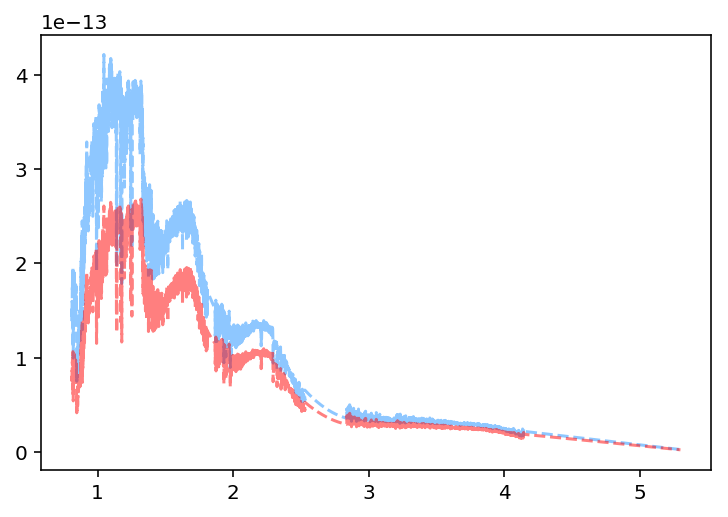

In [2]:
from libra import (IRTFTemplate, magnitudes, 
                   nirspec_pixel_wavelengths, throughput, trappist1, 
                   background, poisson, spitzer_variability)

sptype = 'M8V'
delta_teff = -200
u1, u2 = trappist1('b').u
mag = magnitudes['TRAPPIST-1']['J']
exptime = 1*u.s
n_spots = 3
#times = np.arange(0, 6.6, 1/60/24)
times = np.arange(trappist1('b').t0 - 0.15, trappist1('b').t0 + 3, 1/60/24)
# times = np.arange(trappist1('b').t0 - 0.15, trappist1('b').t0 + 0.15, 1/60/24)
radius_multiplier = 40

spectrum_photo = IRTFTemplate(sptype)
spectrum_spots = spectrum_photo.scale_temperature(delta_teff)

spectrum_photo.plot(label='photosphere', ls='--', color='DodgerBlue', alpha=0.5)
spectrum_spots.plot(label='spots', ls="--", color='r', alpha=0.5)

# # Fractional spotted area
# f_s = 0.5

# combined = (1 - f_s) * spectrum_photo + f_s * spectrum_spots

# combined.plot(label='combination', color='k')

# plt.xlabel('Wavelength [$\mu$m]')
# plt.ylabel('Flux [{0}]'.format(combined.flux.unit.to_string()))

# plt.legend()
# plt.show()

In [3]:
from libra import Star, Spot, trappist1, transit_model

spots = [Spot.from_sunspot_distribution(radius_multiplier=radius_multiplier) 
         for i in range(n_spots)]

star = Star(rotation_period=3.3*u.day, spots=spots, contrast=0.8)

transit = transit_model(times, trappist1('b'))

flux = star.flux(times) * transit

area = star.spotted_area(times)
old_area = star.flux_weighted_area(times)

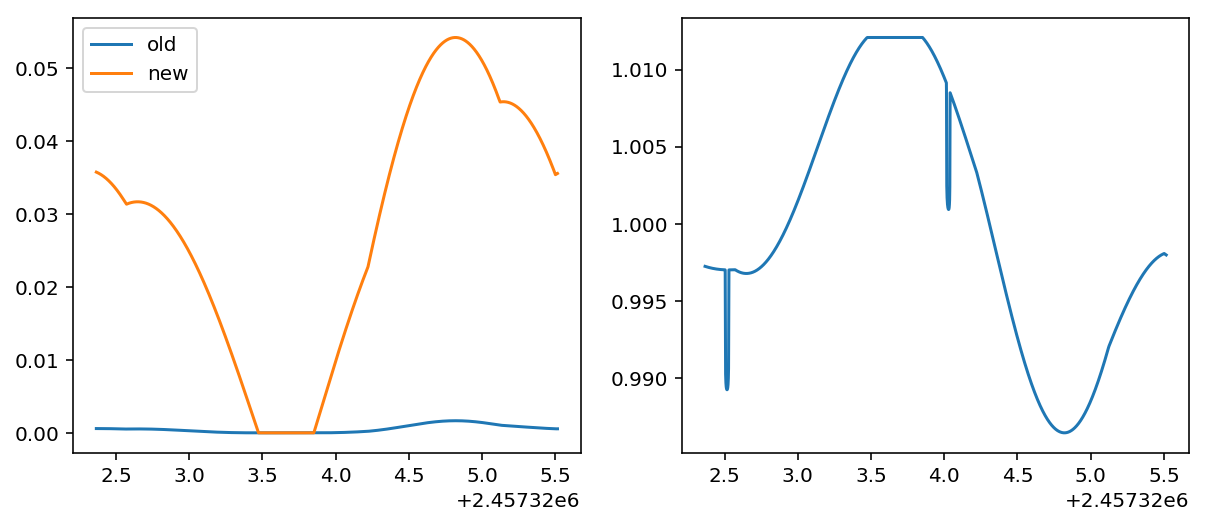

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(times, old_area, label='old')

ax[0].plot(times, area, label='new')
ax[0].legend()

ax[1].plot(times, flux/flux.mean())

In [5]:
wl = nirspec_pixel_wavelengths()
fluxes = np.zeros((len(times), len(wl)))

spitzer_var = spitzer_variability(times)

for i in range(len(times)):
    f_s = area[i]
    combined_spectrum = (1 - f_s) * spectrum_photo + f_s * spectrum_spots
    
    fluxes[i, :] = poisson(combined_spectrum.n_photons(wl, exptime, mag) * transit[i] * 
                           throughput(wl) * spitzer_var[i] + background(wl, exptime))

# Need to do: 

### Create an effective spotted area. it's not the actual spotted area observable on the hemisphere, it's the spotted area weighted by the relative flux in spots.

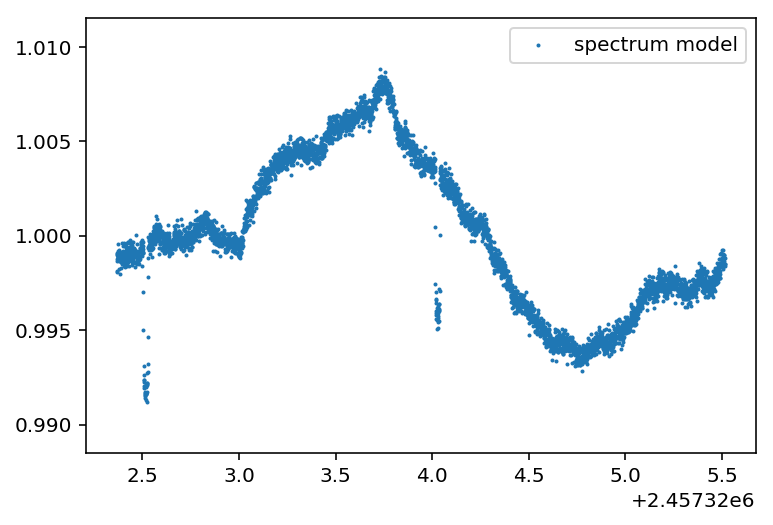

In [6]:
spectral_fluxes = np.sum(fluxes, axis=1)
plt.scatter(times, spectral_fluxes/spectral_fluxes.mean(), 
            marker='.', s=4, label='spectrum model')
plt.legend()
plt.show()

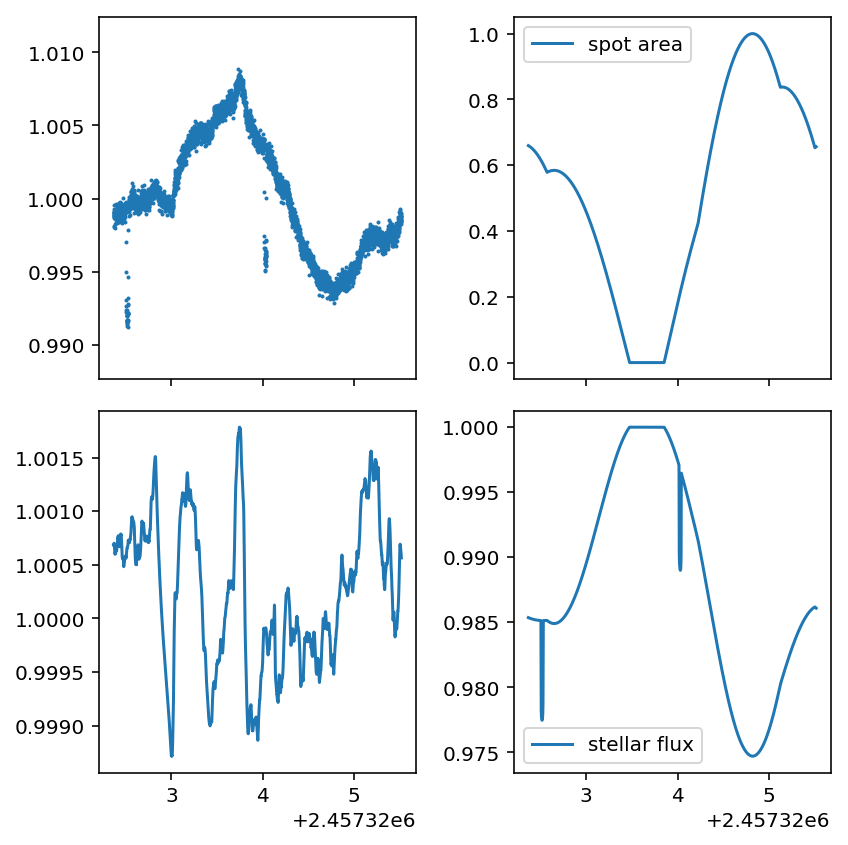

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True)
spectral_fluxes = np.sum(fluxes, axis=1)
ax[0, 0].scatter(times, spectral_fluxes/spectral_fluxes.mean(), 
              marker='.', s=4, label='spectrum model')
ax[0, 1].plot(times, area/area.max(), label='spot area')
ax[0, 1].legend()
ax[1, 1].plot(times, flux/flux.max(), label='stellar flux')
ax[1, 1].legend()
ax[1, 0].plot(times, spitzer_var, label='stellar flux')

#ax[0].plot()
fig.tight_layout()
plt.show()

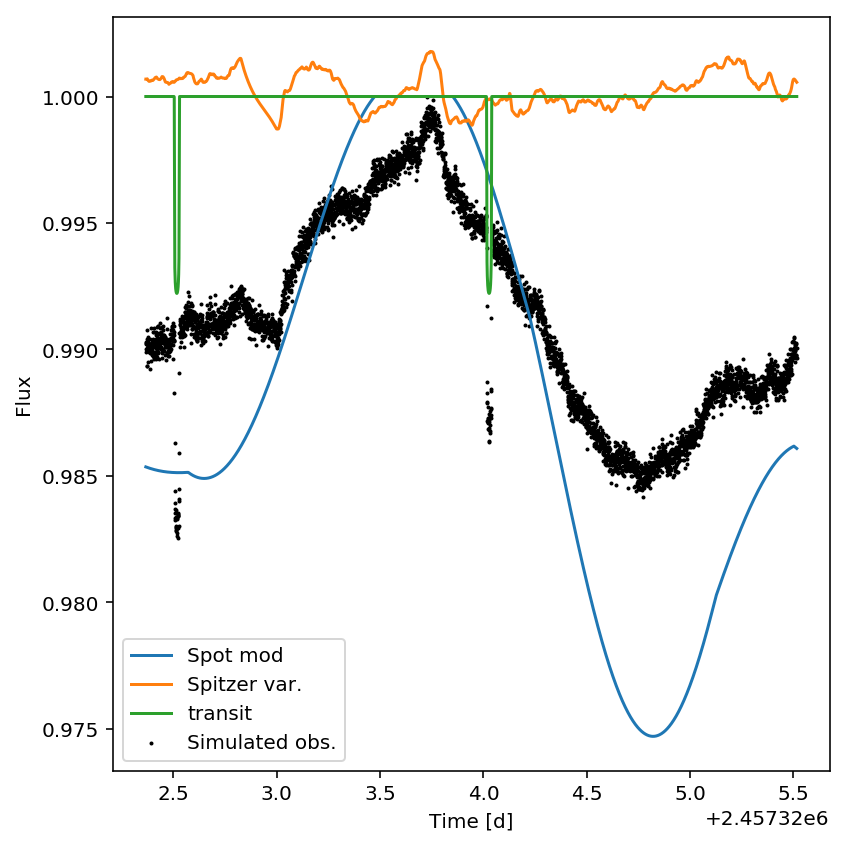

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
spectral_fluxes = np.sum(fluxes, axis=1)
ax.scatter(times, spectral_fluxes/spectral_fluxes.max(), 
           marker='.', s=4, label='Simulated obs.', color='k')
ax.plot(times, star.flux(times)/star.flux(times).max(), label='Spot mod')
ax.plot(times, spitzer_var, label='Spitzer var.')
ax.plot(times, transit, label='transit')
ax.legend()
ax.set_xlabel('Time [d]')
ax.set_ylabel('Flux')
#ax[0].plot()
fig.tight_layout()
fig.savefig('breakdown.png', bbox_inches='tight', dpi=200)
plt.show()

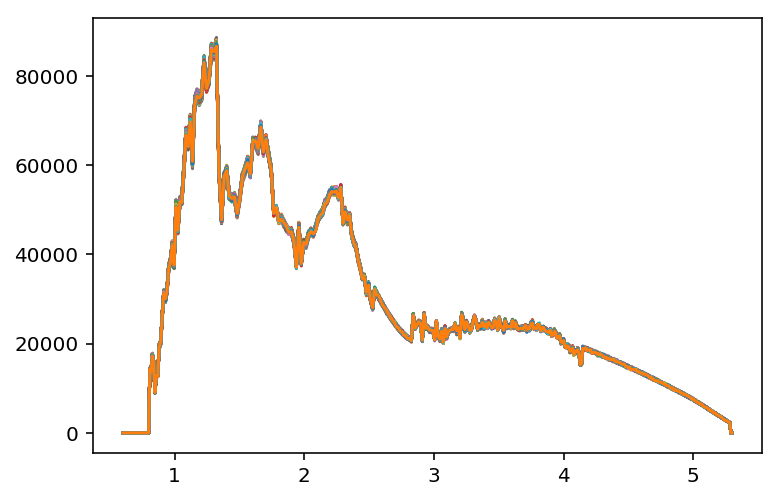

In [44]:
plt.plot(wl, fluxes[::30].T);